In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import cartopy.crs as ccrs
import cartopy
from matplotlib.offsetbox import AnchoredText
import cartopy.feature as cfeature
import scipy.fft as sf
from scipy import special
from scipy import signal
import xarray.ufuncs as xu
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time
import seaborn as sns



The cell above loads the python packages we need to perform this analysis.

In [2]:
def Harmonics(tseries, nmodes=3,missval=np.nan):
    tot = 366 ### Dealing with only 1 year of data here
    mtot=len(tseries)
    time=np.arange(1,mtot+1,1.)
    newdim=len(tseries)  # removing missing data
    harmonic1 =np.zeros((tot))
    tdata=tseries
    svar=np.sum((tdata[:]-np.mean(tdata))**2)//(newdim-1)
    nm=nmodes
    if 2*nm > newdim:
        nm=newdim/2
    coefa=np.zeros((nm))
    coefb=np.zeros((nm))
    hvar=np.zeros((nm))
    for tt in range(0,nm):
        Ak=np.sum(tdata[:]*xu.cos(2.*np.pi*(tt+1)*time[:]/float(newdim)))
        Bk=np.sum(tdata[:]*xu.sin(2.*np.pi*(tt+1)*time[:]/float(newdim)))
        coefa[tt]=Ak*2./float(newdim)
        coefb[tt]=Bk*2./float(newdim)
        hvar[tt]=newdim*(coefa[tt]**2+coefb[tt]**2)/(2.*(newdim-1)*svar)
    harmonic1[:] = np.mean(tseries)
    harmonic1=harmonic1+coefa[0]*np.cos(2.*np.pi*time[:]/float(tot))+coefb[0]*np.sin(2.*np.pi*time[:]/float(tot))
    # if hvar[1] >= hvar[0]:
    #     return np.nan
    # elif hvar[2] >= hvar[0]:
    #     return np.nan
    # else:
    return harmonic1.argmin()

The Harmonics function averages the time series precipitation data and then finds the minimum of the 1st Harmonic. This minimum is then used as the start of the onset calculation.

In [3]:
def onset_calculation(data, data_time, start_test):
    #print(f"data: {data.shape} | time: {data_time.shape} | start_test: {start_test.shape}")
    ### Precalculations ###
    sseries=np.zeros((int(366/2)))
    mtot= len(data)
    yt=-1
    data_time = pd.DatetimeIndex(data_time)
    start_list = np.where(data_time.dayofyear == start_test)[0]
    #print(start_test)
    nyrs = len(np.unique(data_time.year))
    ytot=365
    ### Data Structures to hold results ###
    sjday=np.empty((nyrs))
    sjday[:] = np.nan
    sdate=np.empty((nyrs),dtype='datetime64[D]')
    sdate[:] = 'nat'

    ### Run through entire time series for one grid point ###
    for start in start_list:

        if start < (mtot):         # -5 to avoid calcualtion with short time series for last year
            yt=yt+1
            beg= start
            end = beg+int(365/2)
            if end <= mtot-1:  # it is not the last year
                end2=int(ytot/2)
            if end > mtot-1:
                end=mtot-1
                end2=end-beg
            sseries[:]=0
            sseries[0:end2]=np.cumsum(data[beg:beg+end2])
            #curve[yt,:]=sseries[:]
            #-------------------------------------------------------------------------
            # Calculating onset and demise of the rainy season
            #-------------------------------------------------------------------------
            beg=0
            try:
                ons=np.where(sseries[0:end2] == sseries[0:end2].min())
            except ValueError:
                pass
                #print(beg)
            if len(ons[0]) > 0:
                
                beg=ons[0][0]+start+1
                #print(beg)
            if beg > 0 and beg < end:

                sjday[yt]= data_time[beg].dayofyear
                sdate[yt]= data_time[beg]
                #smonth[yt]= data_time[beg].month
                #syear[yt]= data_time[beg].day
    return sjday

The onset function takes the start date and then takes a cumulative sum of the anomaly precipitation data. The minimum of the cumulative sum is considered the start date. 

In [4]:
def demise_calculation(data, data_time, start_test):
    ### Reverse Date for Demise Calculation
    data = data[::-1]
    data_time = data_time[::-1]
    ### Precalculations ###
    sseries=np.zeros((int(366/2)))
    mtot = len(data)
    yt=-1
    data_time = pd.DatetimeIndex(data_time)
    start_list = np.where(data_time.dayofyear == start_test)[0]
    #print(start_test)
    nyrs = len(np.unique(data_time.year))
    ytot=365
    ### Data Structures to hold results ###
    sjday=np.empty((nyrs))
    sjday[:] = np.nan
    sdate=np.empty((nyrs),dtype='datetime64[D]')
    sdate[:] = 'nat'
    #smonth=np.zeros((nyrs))
    #syear=np.zeros((nyrs))
    ### Run through entire time series for one grid point ###
    for start in start_list:
        #print(start)
        #    for tt in range(0,mtot-5): # -5 to avoid calcualtion with short time series for last year
        #------------------------------------------------------------------------
        # Starting the calculation of accumulated anomalies in the rainy season
        #------------------------------------------------------------------------                 !
        #        if jday[tt] == jstart:
        if start < (mtot):         # -5 to avoid calcualtion with short time series for last year
            yt=yt+1
            beg= start
            end = beg+int(365/2)
            if end <= mtot-1:  # it is not the last year
                end2=int(ytot/2)
            if end > mtot-1:
                end=mtot-1
                end2=end-beg
            sseries[:]=0
            sseries[0:end2]=np.cumsum(data[beg:beg+end2])
            #curve[yt,:]=sseries[:]
            #-------------------------------------------------------------------------
            # Calculating onset and demise of the rainy season
            #-------------------------------------------------------------------------
            beg=0
            try:
                ons=np.where(sseries[0:end2] == sseries[0:end2].min())
            except ValueError:
                #print(beg)
                pass
            if len(ons[0]) > 0:
                beg=ons[0][0]+start+1
                #print(beg)
            if beg > 0 and beg < end:
                data_time = data_time[::-1]
    
                sjday[yt]= data_time[beg].dayofyear
                sdate[yt]= data_time[beg]
                #smonth[yt]= data_time[beg].month
                #syear[yt]= data_time[beg].day
    return sjday

The demise function works the exact same way as the onset function, except the precipitation anomaly data is reversed first so that the function works backwords to find the demise dates.

In [5]:
data = xr.open_dataset('era5_test.nc')
data = data['tp']*1000.0

In [6]:
daily = data.resample(time='1D').sum()

ERA5 data comes from CDS as either monthly or hourly data. The code above turns hourly into daily data.

In [7]:
### Creating the anomaly data
anomaly = daily - daily.mean()

In [84]:
array_jday = anomaly.time.dt.dayofyear
anomaly = anomaly.assign_coords(jday=("time",array_jday.data))

In [85]:
Harmonics(anomaly.groupby('time.dayofyear').mean().values)

/home/gbromley/anaconda3/envs/Narwhal2021/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars


190

Text(0.5, 1.0, 'Desert')

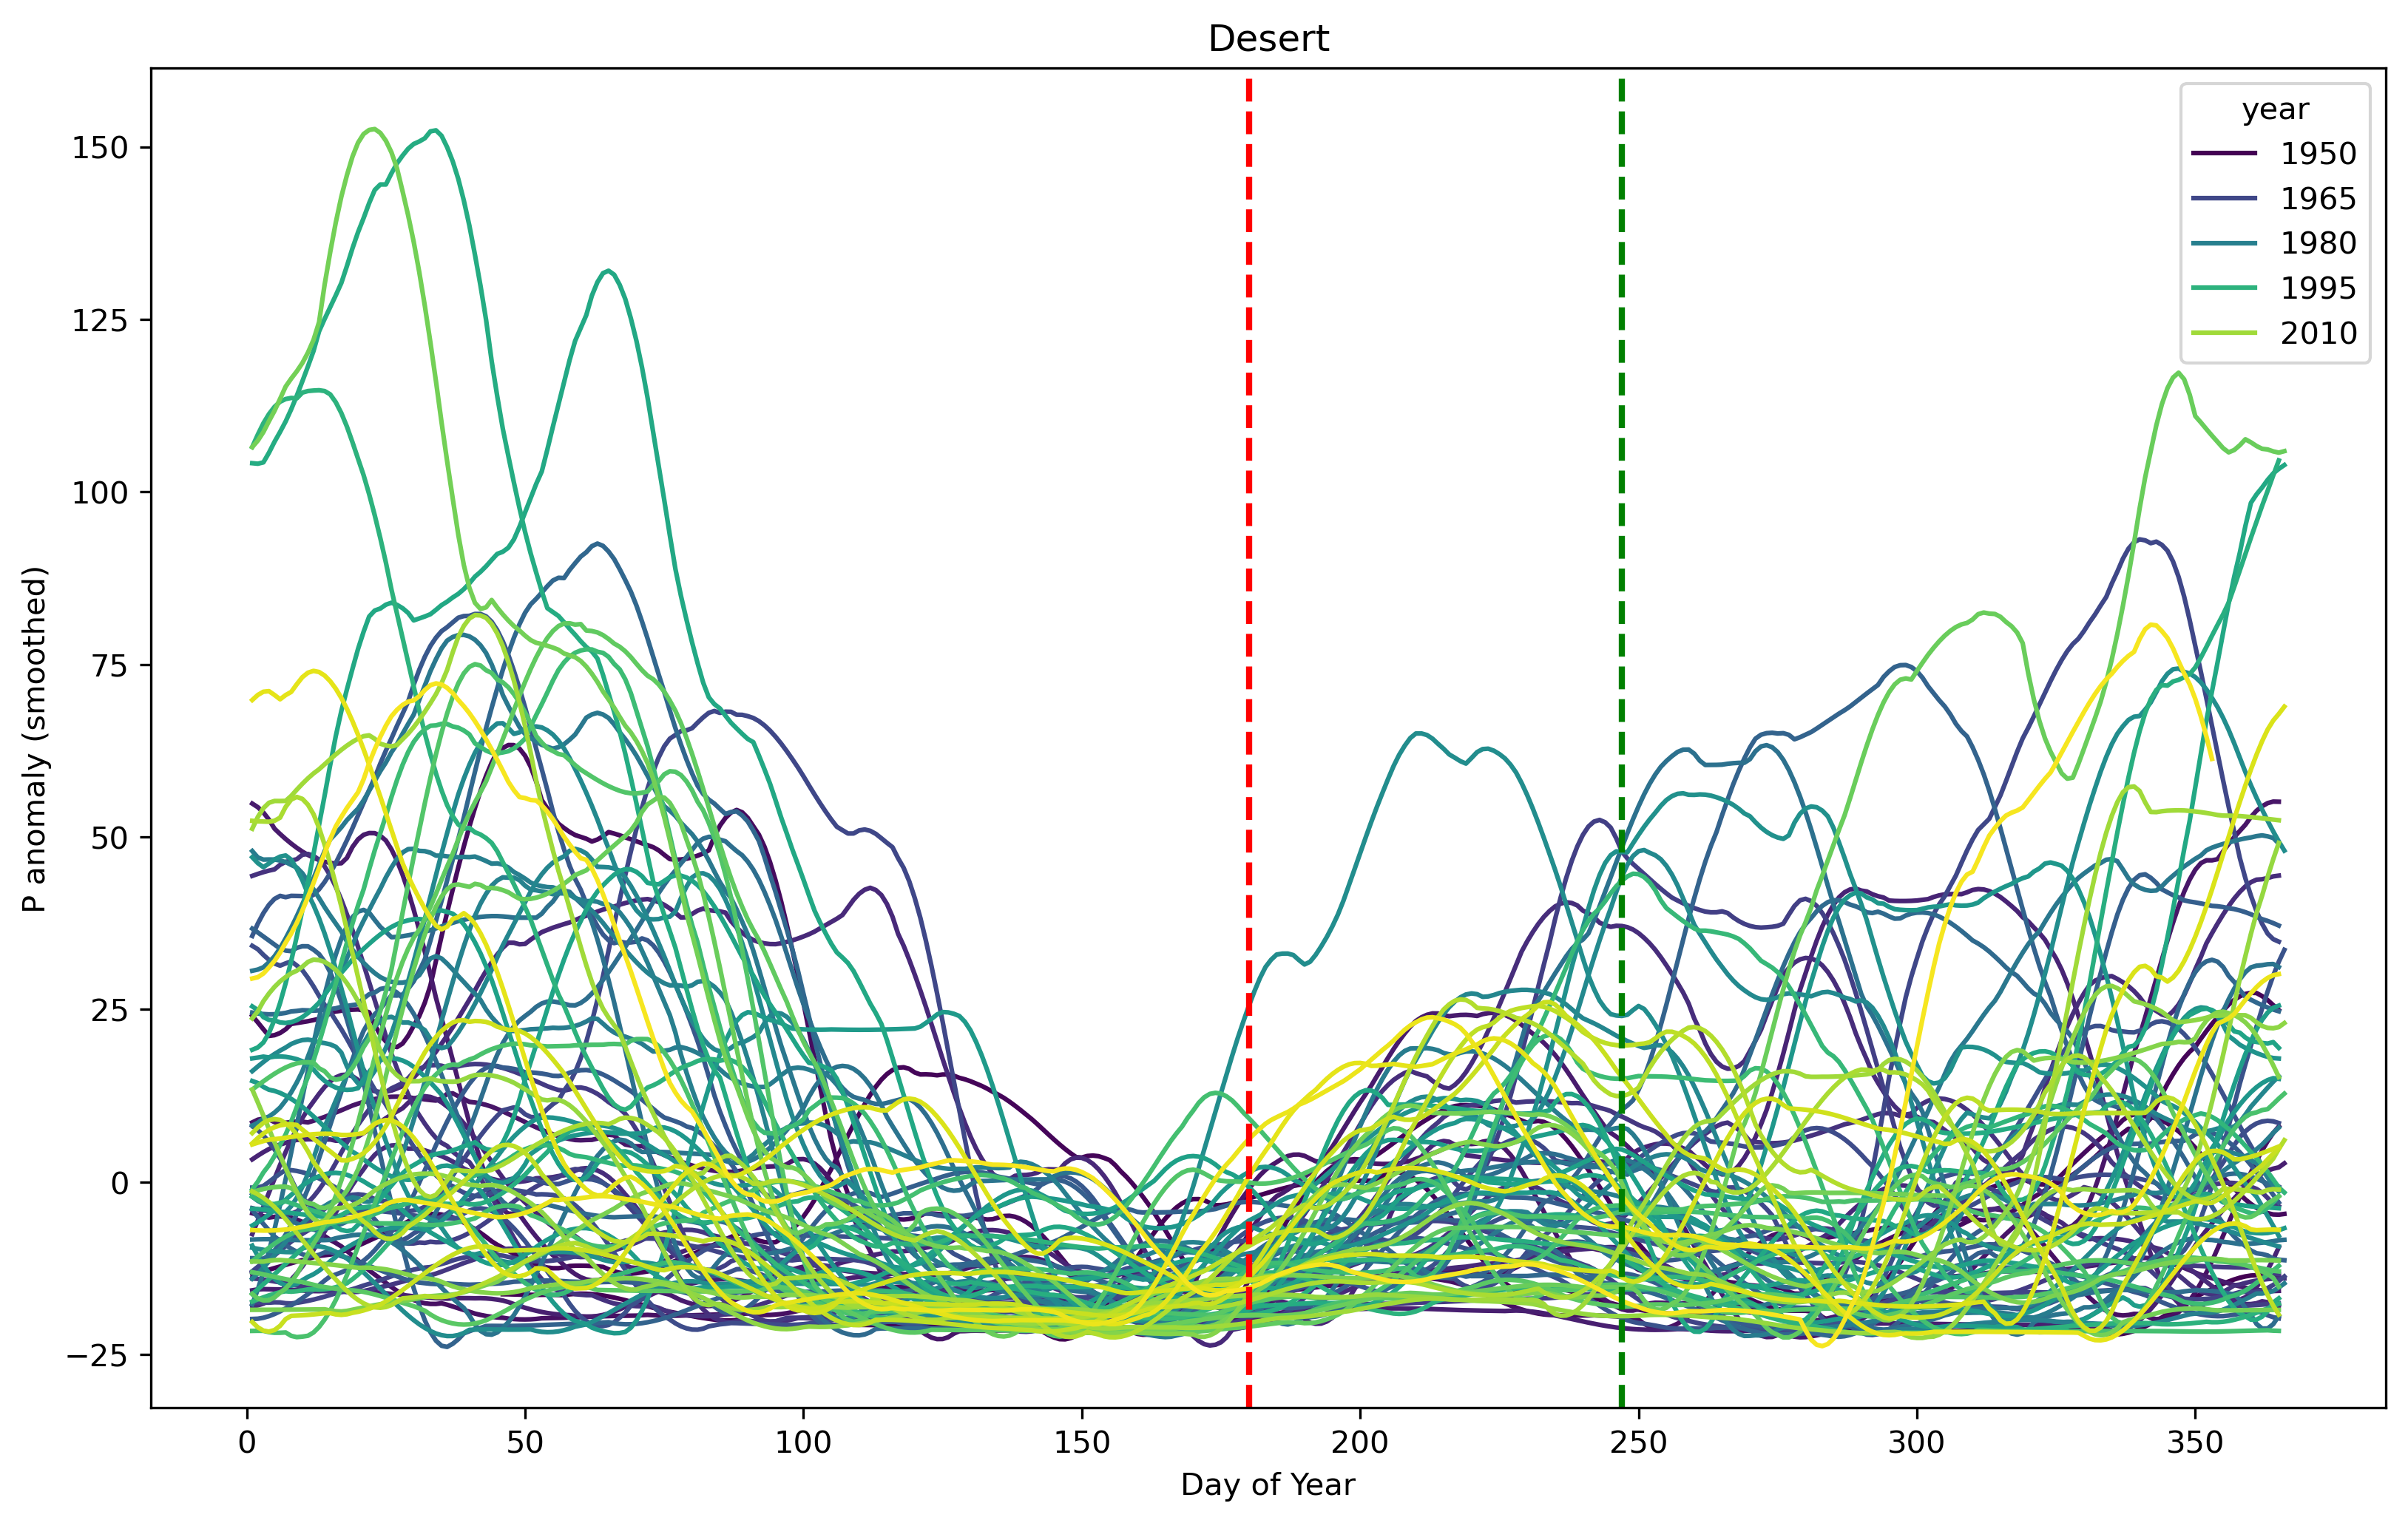

In [91]:
plt.figure(figsize = (13, 8), dpi = 300)

pd_anomaly = anomaly.rolling(time=60,center=True).sum().to_dataframe()
pd_anomaly['time'] = pd_anomaly.index
pd_anomaly['dayofyear'] = pd_anomaly['time'].dt.dayofyear
pd_anomaly['year'] = pd_anomaly['time'].dt.year
pd_anomaly['smooth_tp'] = signal.savgol_filter(pd_anomaly['precip'],31,3)

ax = sns.lineplot(data=pd_anomaly, x='dayofyear',y='smooth_tp',
                  hue='year', palette='viridis')
ax.axvline(247, color='g', linestyle='--', lw=2)
ax.axvline(180, color='r', linestyle='--', lw=2)
ax.set_ylabel('P anomaly (smoothed)')
ax.set_xlabel('Day of Year')
ax.set_title('Desert')


In [25]:
demise_calculation(daily.sel(time='2009').values, daily.sel(time='2009').time,245)

array([122.])

In [24]:
hvar

array([inf, inf, inf])

In [12]:
test = xr.open_dataset('wetseason.onset.era5.nc')

In [20]:
test['onset_date'].sel(latitude=33,longitude=273).sel(year=2009)

<xarray.DataArray 'onset_date' ()>
array(51.)
Coordinates:
    longitude  float32 273.0
    latitude   float32 33.0
    year       int64 2009

In [27]:
test2 = xr.open_dataset('wetseason.demise.era5.nc')


In [28]:
test2['demise_date'].sel(latitude=33,longitude=273).sel(year=2009)

<xarray.DataArray 'demise_date' ()>
array(48.)
Coordinates:
    longitude  float32 273.0
    latitude   float32 33.0
    year       int64 2009